In [158]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
from dm21cm.data_loader import load_data
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges

sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

## dm21cm

In [2]:
dep_tf = load_data(
    'phot_dep',
    prefix=os.environ['DM21CM_DATA_DIR'] + '/tf/230408x/phot',
    reload=True
)

INFO:root:Loaded photon deposition transfer function.


### dm21cm: 1 photon

In [3]:
spec_N = np.zeros((500,))
spec_N[300] = 1.
photeng = dep_tf.abscs['Ein']
print(f'total energy = {np.dot(spec_N, photeng)}')

total energy = 1158962.0723298236


In [134]:
rs_grid = np.geomspace(5, 50, 10)
#rs = np.sqrt(rs_grid[-2]*rs_grid[-3])
rs_start = rs_grid[1]
rs_end = rs_start / 1.05
xe = 0.001
print(rs_start)

6.457748325074419


In [149]:
dm21cm_dep = dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs_start,
    nBs_s = jnp.array([1.]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / np.dot(spec_N, photeng)

dm21cm_dep = np.array(dm21cm_dep).flatten()

## DH

In [136]:
soln = dh_evolve(
    in_spec_phot = Spectrum(photeng, spec_N, spec_type='N', rs=rs),
    rate_func_N = lambda rs: 1.,
    DM_process='swave', mDM=2*photeng[300], sigmav=1e-100, primary='phot_delta',
    start_rs=rs_start, end_rs=rs_end,
    coarsen_factor=1, backreaction=False, 
    struct_boost=lambda rs: 1.,
    reion_switch=True, reion_rs = 50,
    photoion_rate_func = [lambda rs: 0.] * 3,
    photoheat_rate_func = [lambda rs: 0.] * 3,
    xe_reion_func = lambda rs: xe,
    use_tqdm=False, verbose=1
)

Loading time: 0.000 s
Initialization time: 0.023 s
Main loop time: 1.247 s


In [137]:
np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])

array([[0.00000000e+00, 5.13073474e-07, 1.02605576e-06, 1.53894342e-06,
        2.05173304e-06, 2.56442114e-06, 3.07700426e-06, 3.58947888e-06,
        4.10184150e-06, 4.61408858e-06, 5.12621656e-06, 5.63822187e-06,
        6.15010090e-06, 6.66185005e-06, 7.17346567e-06, 7.68494411e-06,
        8.19628170e-06, 8.70747474e-06, 9.21851951e-06, 9.72941227e-06,
        1.02401493e-05, 1.07507267e-05, 1.12611409e-05, 1.17713878e-05,
        1.22814638e-05, 1.27913649e-05, 1.33010873e-05, 1.38106270e-05,
        1.43199801e-05, 1.48291428e-05, 1.53381109e-05, 1.58468806e-05,
        1.63554478e-05, 1.68638085e-05, 1.73719587e-05, 1.78798942e-05,
        1.83876110e-05, 1.88951049e-05, 1.94023719e-05, 1.99094077e-05,
        2.04162081e-05, 2.09227690e-05, 2.14290862e-05, 2.19351553e-05,
        2.24409722e-05, 2.29465324e-05, 2.34518318e-05, 2.39568659e-05,
        2.44616304e-05],
       [0.00000000e+00, 7.95812680e-09, 1.59142952e-08, 2.38685065e-08,
        3.18207624e-08, 3.97710641e-08,

In [147]:
dh_dep = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
dh_dep = np.sum(dh_dep, axis=-1)

In [145]:
dh_dep = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
dh_dep = dh_dep[:,1]

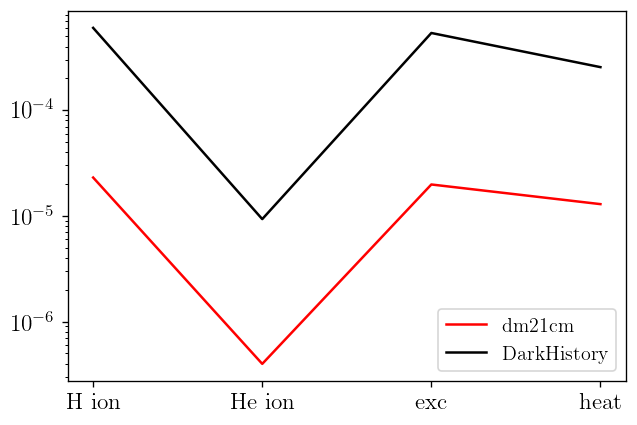

In [150]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()
ax.plot(dm21cm_dep[:4], label='dm21cm', color='r')
ax.plot(dh_dep[:4], label='DarkHistory', color='k')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

## loop over rs

In [166]:
f_ratios_arr = []

for rs in tqdm(np.geomspace(5, 50, 100)):
    rs_start = rs
    rs_end = rs_start / 1.05
    xe = 0.001
    dm21cm_dep = dep_tf(
        in_spec = spec_N,
        sum_result = False,
        rs = rs_start,
        nBs_s = jnp.array([1.]),
        x_s = jnp.array([xe]),
        out_of_bounds_action = 'clip',
    ) / np.dot(spec_N, photeng) / (0.04879016/0.001)

    dm21cm_dep = np.array(dm21cm_dep).flatten()

    soln = dh_evolve(
        in_spec_phot = Spectrum(photeng, spec_N, spec_type='N', rs=rs_start),
        rate_func_N = lambda rs: 1.,
        DM_process='swave', mDM=2*photeng[300], sigmav=1e-100, primary='phot_delta',
        start_rs=rs_start, end_rs=rs_start/1.001**3,
        coarsen_factor=1, backreaction=False, 
        struct_boost=lambda rs: 1.,
        reion_switch=True, reion_rs = 50,
        photoion_rate_func = [lambda rs: 0.] * 3,
        photoheat_rate_func = [lambda rs: 0.] * 3,
        xe_reion_func = lambda rs: xe,
        use_tqdm=False, verbose=0
    )

    dh_dep = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
    dh_dep = dh_dep[:,1]

    f_ratios_arr.append(dh_dep[:4]/dm21cm_dep[:4])
    
f_ratios_arr = np.array(f_ratios_arr)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.64it/s]


[None]

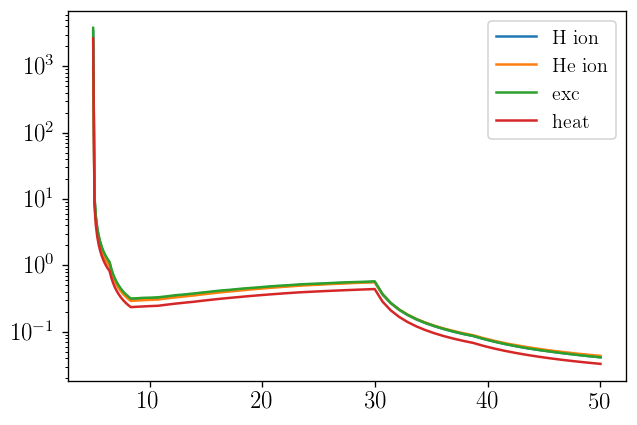

In [169]:
fig, ax = plt.subplots()

rs_arr = np.geomspace(5, 50, 100)
ax.plot(rs_arr, f_ratios_arr[:, 0], label='H ion')
ax.plot(rs_arr, f_ratios_arr[:, 1], label='He ion')
ax.plot(rs_arr, f_ratios_arr[:, 2], label='exc')
ax.plot(rs_arr, f_ratios_arr[:, 3], label='heat')

ax.legend()
ax.set(yscale='log')

### dm21cm: DM

In [35]:
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
)

In [36]:
z_edges = get_z_edges(44, 6, 1.05)

In [37]:
z_early, z_late, z_mid = z_edges[3], z_edges[4], np.sqrt(z_edges[3]*z_edges[4])

In [38]:
z_mid

36.68125290890279

In [40]:
dt = phys.dt_between_z(z_early, z_late)
n_Bavg = phys.n_B * (1+z_mid)**3 # [Bavg cm^-3]
delta_box = 0.
struct_boost = 1.
rho_DM_box = (1 + delta_box) * phys.rho_DM * (1+z_mid)**3 # [eV cm^-3]
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * struct_boost / n_Bavg
dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box)
dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / struct_boost

In [41]:
dE_inj_per_Bavg_unclustered

0.05832310611619097

In [42]:
records = np.load("../../data/run_info/phph_dhinit_s8zero_records.npy", allow_pickle=True).item()

In [43]:
x_e = interpolate.interp1d(records['z'], records['x_e'])(z_mid).item()

In [44]:
x_e

0.006042476201550739

In [47]:
inj_per_Bavg_box

2.916155305809549e-12

In [48]:
dep_tf(in_spec=dm_params.inj_phot_spec.N, sum_result=False, rs = 1+z_mid,
       nBs_s = jnp.array([1.]),
       x_s = jnp.array([x_e]),
       out_of_bounds_action = 'clip',) * inj_per_Bavg_box / dE_inj_per_Bavg_unclustered

Array([[4.6513392e-08, 7.2935558e-10, 3.9496822e-08, 4.0667299e-08,
        6.2892513e-09, 1.2869677e-04]], dtype=float32)

In [56]:
dh_evolve?

Signature:
dh_evolve(
    in_spec_elec=None,
    in_spec_phot=None,
    rate_func_N=None,
    rate_func_eng=None,
    DM_process=None,
    mDM=None,
    sigmav=None,
    lifetime=None,
    primary=None,
    struct_boost=None,
    start_rs=None,
    end_rs=4,
    helium_TLA=False,
    reion_switch=False,
    reion_rs=None,
    photoion_rate_func=None,
    photoheat_rate_func=None,
    xe_reion_func=None,
    init_cond=None,
    coarsen_factor=1,
    backreaction=True,
    compute_fs_method='no_He',
    mxstep=1000,
    rtol=0.0001,
    use_tqdm=True,
    cross_check=False,
    tf_mode='table',
    verbose=0,
)
Docstring:
Main function computing histories and spectra. 

Parameters
-----------
in_spec_elec : :class:`.Spectrum` or function, optional
    Spectrum per injection event into electrons. *in_spec_elec.rs*
    of the :class:`.Spectrum` must be the initial redshift. 
    Alternatively, a function taking :math:`(1+z)` as input and output a
    :class:`.Spectrum` object with the corr